In [62]:
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
import tensorflow.keras.preprocessing.image 
import cv2
import matplotlib.pyplot as plt

In [63]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2511627021383592973
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2258055988
locality {
  bus_id: 1
  links {
  }
}
incarnation: 394299198123578898
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [64]:
path = "E:\deep learning project\inaturalist_12K"

In [65]:
def get_data(path,augmentation=True):
    train_path=os.path.join(path,"train")
    test_path=os.path.join(path,"val")
    if augmentation==False:
        train_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.1)
    else:
        train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                          rotation_range=90,
                                                                          zoom_range=0.2,
                                                                          shear_range=0.2,
                                                                          validation_split=0.1,
                                                                          horizontal_flip=True)
    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    train_data = train_generator.flow_from_directory(directory=train_path,
                                                     target_size=(256, 256),
                                                     color_mode="rgb",
                                                     batch_size=32,
                                                     class_mode="categorical",
                                                     shuffle=True,
                                                     seed=42)
    valid_data = train_generator.flow_from_directory(directory=train_path,
                                                     target_size=(256, 256),
                                                     color_mode="rgb",
                                                     batch_size=32,
                                                     class_mode="categorical",
                                                     shuffle=True,
                                                     seed=42)
    test_data=test_generator.flow_from_directory(directory=test_path,
                                                 target_size=(256, 256),
                                                 color_mode="rgb",
                                                 batch_size=32,
                                                 class_mode="categorical",
                                                 shuffle=True,
                                                 seed=42)
    return train_data,valid_data,test_data

In [66]:
image_size=256
output_size=10

In [67]:
import wandb

In [68]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [70]:
from wandb.keras import WandbCallback
class CNN(object):
    def __init__(self, no_conv_layers, kernel_size, learning_rate,
                 epochs,padding, filter_no_metric, dense_layer_size=32,
                 activation_func='relu', no_filters=32, image_size=256,
                 drop_out=0.2,output_size=10, augmentation= True, 
                 batch_normalization=True):
        self.kenel_size = kernel_size
        self.learning_rate = learning_rate
        self.image_size = image_size
        self.output_size = output_size
        self.augmentation = augmentation
        self.batch_normalization = batch_normalization
        self.no_conv_layers = no_conv_layers
        self.dense_layer_size = dense_layer_size
        self.drop_out = drop_out
        self.no_filters = no_filters
        self.epochs = epochs
        self.padding = padding
        self.filter_no_metric = filter_no_metric
        self.activation_func = activation_func
        self.initialize(no_conv_layers, kernel_size, learning_rate,
                        epochs,padding, filter_no_metric, dense_layer_size,
                        activation_func, no_filters, image_size, drop_out,
                        output_size, augmentation, batch_normalization)

    def initialize(self, no_conv_layers, kernel_size, learning_rate,
                   epochs, padding, filter_no_metric, dense_layer_size=32,
                   activation_func='relu', no_filters=32, image_size=256,
                   drop_out=0.2, output_size=10, augmentation=True,
                   batch_normalization=True):
        self.model=Sequential()
        for i in range(0,no_conv_layers):
            if i==0:
                self.model.add(Conv2D(no_filters, kernel_size,
                                      input_shape=(image_size, image_size, 3),
                                      kernel_initializer = "he_uniform",
                                      padding = padding,
                                      data_format="channels_last"))
            else:
                if filter_no_metric=="1":
                    self.model.add(Conv2D(no_filters, kernel_size, kernel_initializer="he_uniform", padding=padding))
                elif filter_no_metric=="2":
                    self.model.add(Conv2D(no_filters*(2**i),kernel_size,
                                          kernel_initializer="he_uniform",
                                          padding=padding))
                elif filter_no_metric=="1/2":
                    self.model.add(Conv2D(no_filters*(1/(2**i)), kernel_size,
                                          kernel_initializer="he_uniform",
                                          padding=padding))

            self.model.add(Activation(activation_func))
            if batch_normalization==True:
                self.model.add(BatchNormalization())
            self.model.add(MaxPooling2D(pool_size=(2,2)))
        if batch_normalization==True:
            self.model.add(BatchNormalization())
        self.model.add(Flatten())
        self.model.add(Dense(dense_layer_size))
        self.model.add(Activation(activation_func))
        if batch_normalization==True:
            self.model.add(BatchNormalization())
        self.model.add(Dropout(drop_out))
        self.model.add(Dense(output_size))
        self.model.add(Activation("softmax"))

In [71]:
import numpy as np
from tensorflow.keras.optimizers import Adam
np.random.seed(2)
classes=["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]
train_data, valid_data, test_data= get_data(path, False)
best_model=CNN(5, (4,4),0.001, 10, 'same', '1',128, 'selu',
              32, image_size, 0.4, output_size,False, True)
best_model.model.compile(optimizer=Adam(0.001),  # Optimizer
                         loss="categorical_crossentropy",
                         metrics="categorical_accuracy")
best_model.model.fit(train_data, epochs=10, batch_size=64, validation_data=valid_data)

Found 9999 images belonging to 10 classes.
Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
313/313 [==============================] - 481s 2s/step - loss: 2.4593 - categorical_accuracy: 0.2134 - val_loss: 2.1132 - val_categorical_accuracy: 0.2761
Epoch 2/10
313/313 [==============================] - 401s 1s/step - loss: 2.1150 - categorical_accuracy: 0.2816 - val_loss: 1.8406 - val_categorical_accuracy: 0.3477
Epoch 3/10
313/313 [==============================] - 392s 1s/step - loss: 1.9727 - categorical_accuracy: 0.3017 - val_loss: 1.9739 - val_categorical_accuracy: 0.3056
Epoch 4/10
313/313 [==============================] - 395s 1s/step - loss: 1.8753 - categorical_accuracy: 0.3400 - val_loss: 1.7066 - val_categorical_accuracy: 0.3992
Epoch 5/10
313/313 [==============================] - 1154s 4s/step - loss: 1.7921 - categorical_accuracy: 0.3725 - val_loss: 1.7376 - val_categorical_accuracy: 0.4016
Epoch 6/10
313/313 [===============

In [146]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(20,30))
def test(model,test_path,test_data,cls,classes):
    global k
    k=1
    img_path=os.path.join(test_path,cls)
    lst=os.listdir(img_path)
    x=[]
    pred=[]
    true=[]
    i=0
    #fig=plt.figure(figsize=(20,30))
    for img in lst:
        if i!=3:
            try:
                image = cv2.imread(os.path.join(img_path,img))
                #plt.imshow(image)
                image=cv2.resize(image,(image_size,image_size))
                x.append(image)
                plt.imshow(image)
                plt.show()
                image=image/255
                pred=model.predict(image.reshape(1,image_size,image_size,3))
                c=pred.argmax()
                #plt.title("True_label-"+cls+"\n"+"pred_label-"+classes[c])
                pred.append(classes[c])
                true.append(cls)
                i=i+1
                print("akash")
            except:
                break
            #i=i+1
        else:
            break
        
        


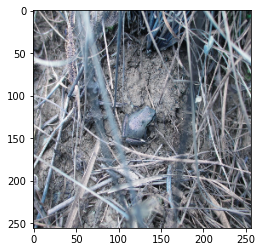

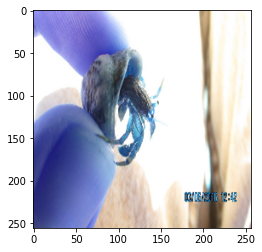

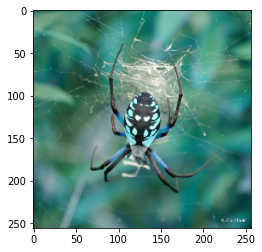

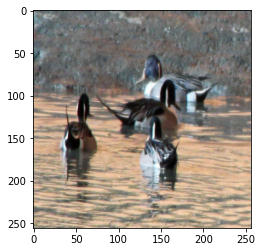

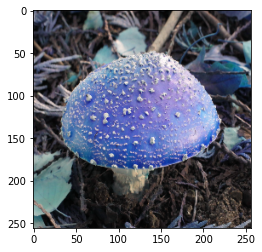

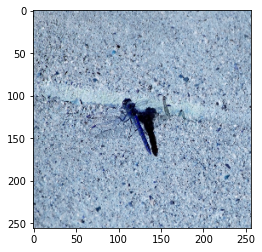

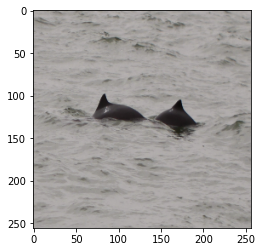

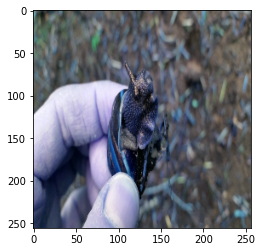

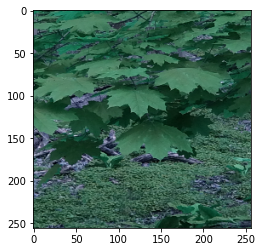

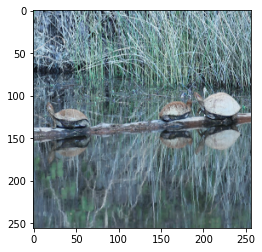

In [147]:

test_path=os.path.join(path,"val")
for cls in classes:
    test(best_model.model,test_path,test_data,cls,classes)

In [158]:
save_model = "./best_model.h5"
#!ls $save_model

#best_model.model.save(save_model)
model = tf.keras.models.load_model(save_model)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 256, 256, 32)      1568      
_________________________________________________________________
activation_21 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 32)      16416     
_________________________________________________________________
activation_22 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 32)     

In [ ]:
wandb.init(project="test", entity="cs21m003_cs21d406")
wandb.log({"image":plt})

In [100]:
best_model.model.evaluate(test_data, batch_size=256)

63/63 [==============================] - 41s 661ms/step - loss: 1.9154 - categorical_accuracy: 0.3715


[1.9154198169708252, 0.3714999854564667]

In [76]:
best_model.model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 256, 256, 32)      1568      
_________________________________________________________________
activation_21 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 32)      16416     
_________________________________________________________________
activation_22 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 32)     

In [57]:
from tensorflow.keras.models import Sequential, Model
import random
def plot_first_layer_filter(test_data,classes,model,layer='conv2d_10'):
    outputs =model.get_layer(layer).output
    inputs=model.inputs
    filter_maps_output=Model(inputs=inputs,outputs=outputs)
    length=len(classes)
    n_2=random.randrange(test_data[0][0].shape[0])
    n_3=random.randrange(test_data[0][0].shape[0])
    filter_1=filter_maps_output(test_data[n_2][0])
    plt.imshow(test_data[n_2][0][n_3])
    plt.axis("off")
    wandb.init(project="filter", entity="cs21m003_cs21d406")
    wandb.log({"true_image":plt})
    no_filters=filter_1.shape[3]
    figsize=(30,30)
    fig=plt.figure(figsize=figsize)
    k=1
    rows = 8
    columns=4
    for i in range(no_filters):
        fig.add_subplot(rows,columns,k)
        plt.imshow(filter_1[n_3,:,:,i])
        plt.title(str(i+1)+"_filter")
        plt.axis("off")
        k=k+1
    wandb.log({"filters":plt})
        
    

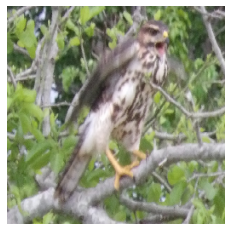

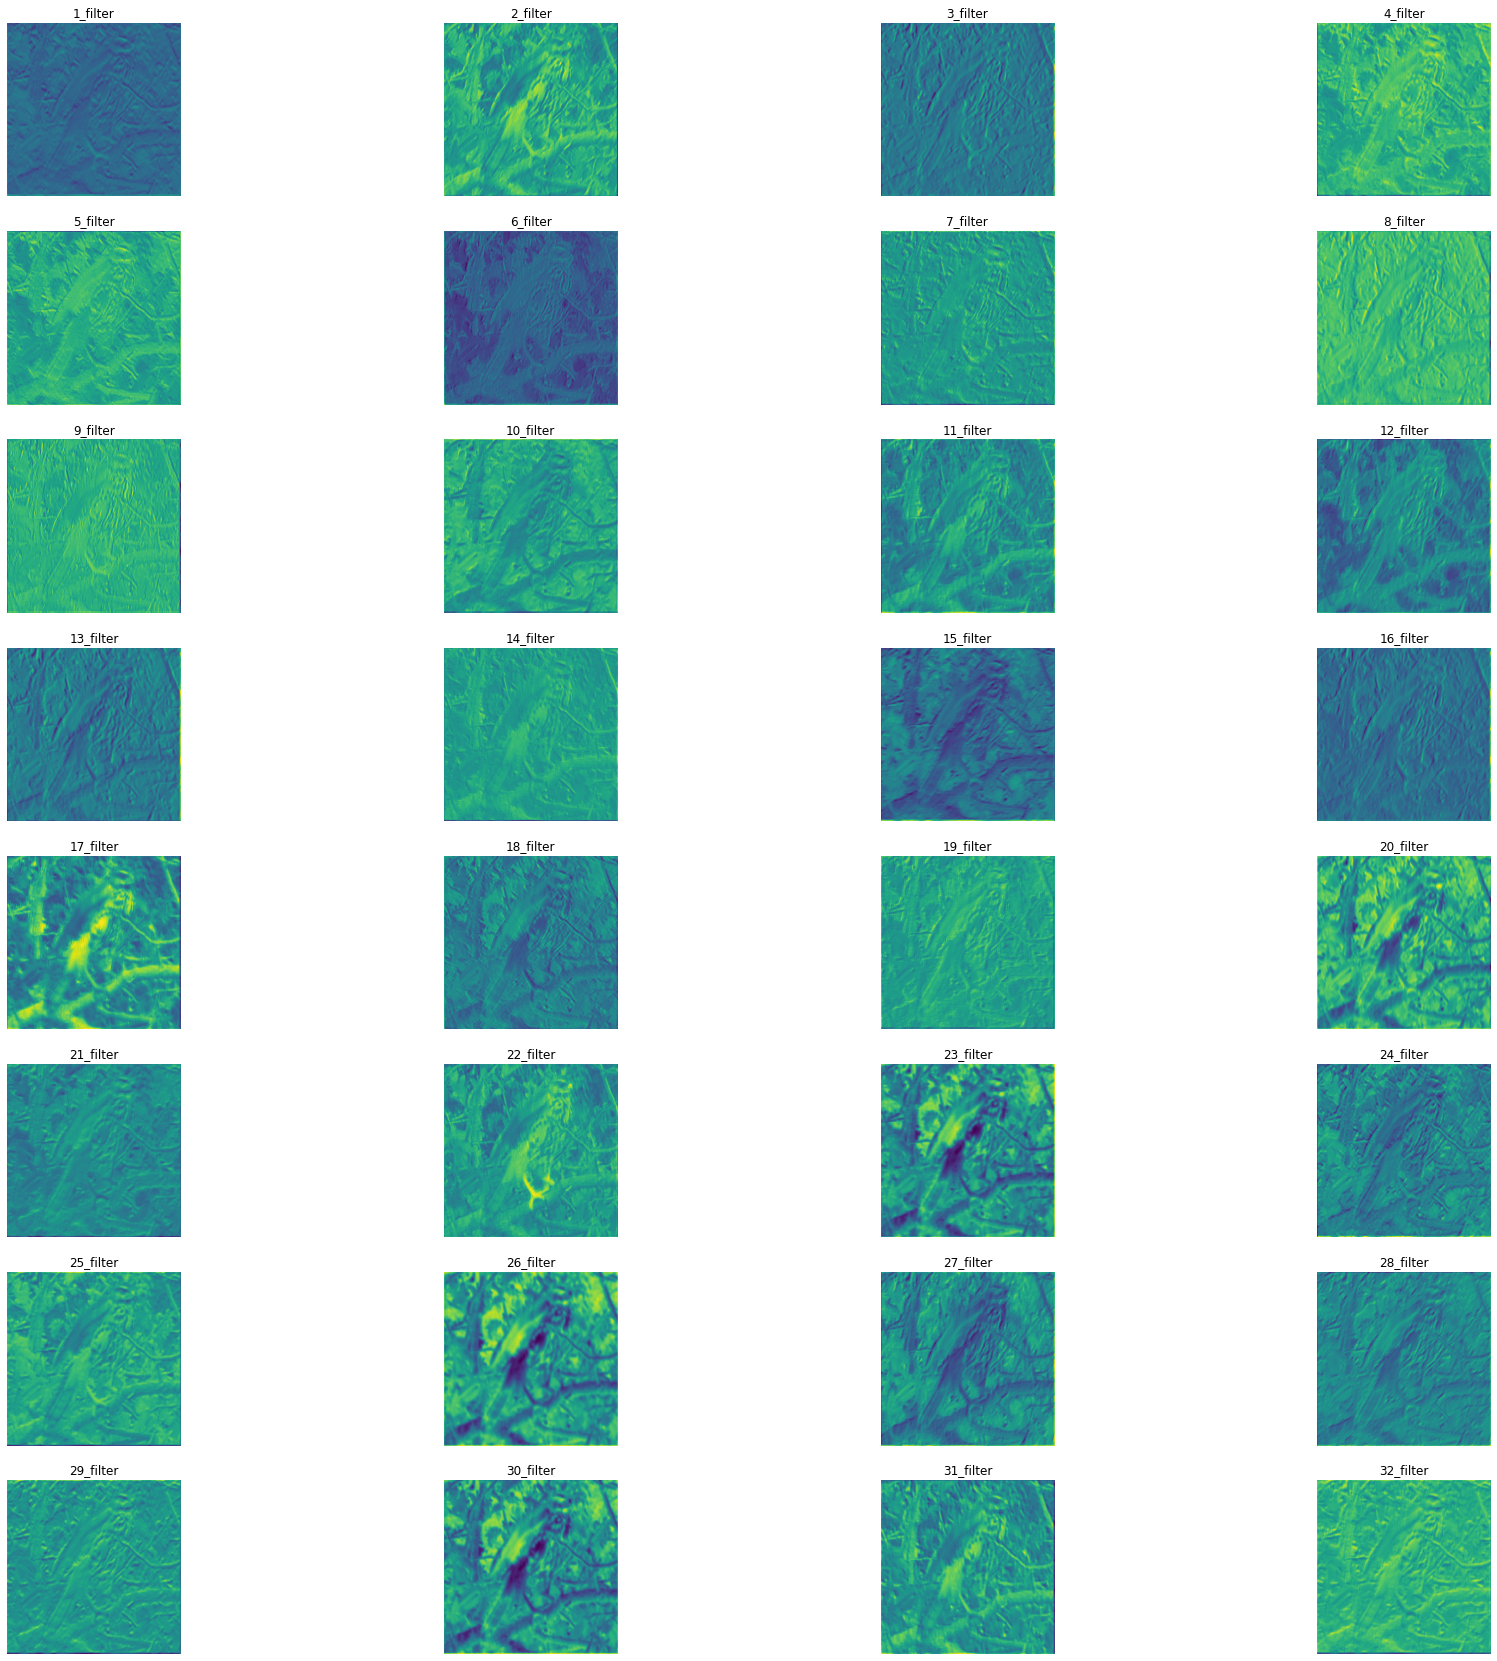

In [58]:
plot_first_layer_filter(test_data,classes,best_model.model,'conv2d_10')

In [59]:
best_model.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 256, 32)      1568      
_________________________________________________________________
activation_14 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 32)      16416     
_________________________________________________________________
activation_15 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 128, 32)     